### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge 
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
from pylab import rcParams

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Data Preprcessing

In [2]:
mks = pd.read_csv("data/MKSfull.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

### Create Features Dataframes

In [4]:
def create_dataframes(X_len, days):
    use = mks.tail(X_len + days)
    Χ_columns = []
    for j in range(days):
        Χ_columns.append('i+%s' % str(j))

    X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
    y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    for i in range(X_len):
        for j in range(days):
            X.iloc[i]['i+%s' % str(j)] = use.iloc[i + j]['Close']
        y.iloc[i] = use.iloc[(i + j + 1)]['Close']
        
    return X, y

### Split train/test set

In [5]:
def split_train_test_set(X, y, test_size=0.3):  
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

### Define metrics

In [6]:
def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

### Benchmark model, persistence

In [7]:
def identity(x):
    return x

def model_persistence(test_X, days):
    predictions = list()
    for x in test_X['i+%s' % str(days-1)]:
        yhat = identity(x)
        predictions.append(yhat)
    return predictions

### Define, Train Regressors: Linear, Ridge, Linear SVM

In [8]:
def get_linear_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X, y)
    return grid.best_estimator_

def get_ridge_model(X, y):
    r_reg = Ridge()
    r_reg.fit(X, y)
    return r_reg

def get_lsvr_model(X, y):
    svr = LinearSVR()
    svr.fit(X, y.values.ravel())
    return svr

### KFolds cross validation

In [9]:
def create_cv_sets(X, y, n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets


X_size = 300
days = 10


n_splits = 23
linear_errs=[]
benchmark_errs=[]
linear_models=[]
X,y = create_dataframes(7000, days)
for X_train, X_test, y_train, y_test in create_cv_sets(X, y, n_splits, X_size ):
    linear_model = get_linear_model(X_train, y_train) 
    linear_models.append(linear_model)
    linear_pred = linear_model.predict(X_test)
    linear_errs.append((rmse(y_test, linear_pred)))
    benchmark_pred = model_persistence(X_test, days)
    benchmark_errs.append(rmse(y_test['Close'], benchmark_pred))


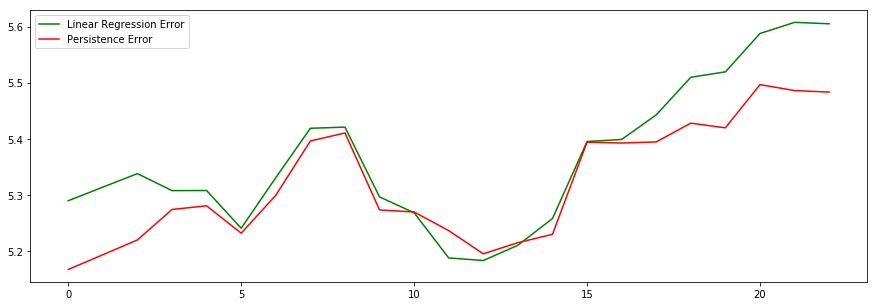

In [10]:
rcParams['figure.figsize'] = 15,5

t = range(n_splits)
plt.plot(t, linear_errs, 'g', label='Linear Regression Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')

plt.legend()
plt.show()

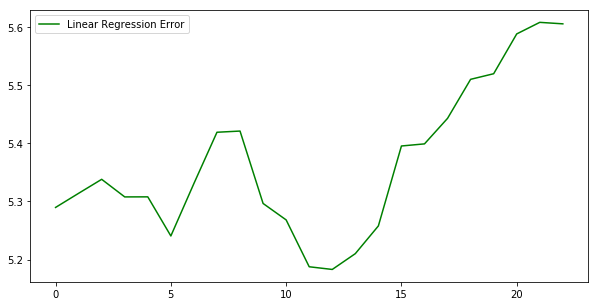

In [15]:
rcParams['figure.figsize'] = 10,5

t = range(n_splits)
plt.plot(t, linear_errs, 'g', label='Linear Regression Error')


plt.legend()
plt.show()

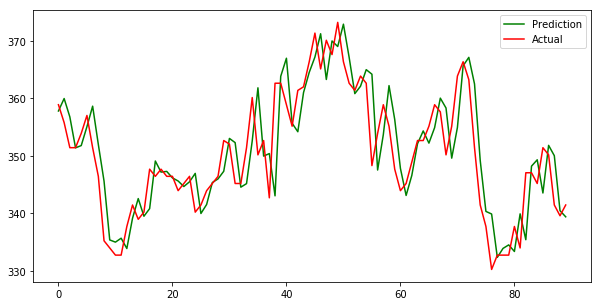

In [11]:
rcParams['figure.figsize'] = 10,5

t = range(len(X_test))
plt.plot(t, linear_model.predict(X_test), 'g', label='Prediction')
plt.plot(t, y_test, 'r', label='Actual')

plt.legend()
plt.show()

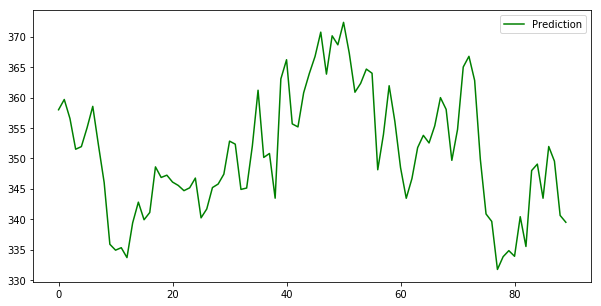

In [12]:
rcParams['figure.figsize'] = 10,5

t = range(len(X_test))
plt.plot(t, linear_models[10].predict(X_test), 'g', label='Prediction')


plt.legend()
plt.show()

In [13]:
from sklearn.externals import joblib
joblib.dump(linear_models[10], 'prediction_model_full.pkl')

['prediction_model_full.pkl']